# Parallel simulations

Download the Jupyter notebook : [MultipleNetworks.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/docs/example/MultipleNetworks.ipynb)

This example demonstrates the use of `parallel_run()` to simulate the same network multiple times in parallel. 

We start by creating the Izhikevich pulse-coupled network defined in [Izhikevich.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/docs/example/Izhikevich.ipynb).

In [1]:
from ANNarchy import *
clear()

# Create the whole population
P = Population(geometry=1000, neuron=Izhikevich)

# Create the excitatory population
Exc = P[:800]
re = np.random.random(800)
Exc.noise = 5.0
Exc.a = 0.02
Exc.b = 0.2
Exc.c = -65.0 + 15.0 * re**2
Exc.d = 8.0 - 6.0 * re**2
Exc.v = -65.0
Exc.u = Exc.v * Exc.b

# Create the Inh population
Inh = P[800:]
ri = np.random.random(200)
Inh.noise = 2.0
Inh.a = 0.02 + 0.08 * ri
Inh.b = 0.25 - 0.05 * ri
Inh.c = -65.0
Inh.d = 2.0
Inh.v = -65.0
Inh.u = Inh.v * Inh.b

# Create the projections
proj_exc = Projection(Exc, P, 'exc')
proj_inh = Projection(Inh, P, 'inh')

proj_exc.connect_all_to_all(weights=Uniform(0.0, 0.5))
proj_inh.connect_all_to_all(weights=Uniform(0.0, 1.0))

# Create a spike monitor
M = Monitor(P, 'spike')

compile()


ANNarchy 4.7 (4.7.2) on darwin (posix).


We define a simulation method that re-initializes the network, runs a simulation and returns a raster plot. 

The simulation method must take an index as first argument and a ``Network`` instance as second one.

In [2]:
def run_network(idx, net):
    # Retrieve subpopulations
    P_local = net.get(P)
    Exc = P_local[:800]
    Inh = P_local[800:]
    # Randomize initialization
    re = np.random.random(800)
    Exc.c = -65.0 + 15.0 * re**2
    Exc.d = 8.0 - 6.0 * re**2
    ri = np.random.random(200)
    Inh.noise = 2.0
    Inh.a = 0.02 + 0.08 * ri
    Inh.b = 0.25 - 0.05 * ri
    Inh.u = Inh.v * Inh.b
    # Simulate
    net.simulate(1000.)
    # Recordings
    t, n = net.get(M).raster_plot()
    return t, n


``parallel_run()`` uses the ``multiprocessing`` module to start parallel processes. On Linux, it should work directly, but there is an issue on OSX. Since Python 3.8, the 'spawn' method is the default way to start processes, but it does not work on MacOS. The following cell should fix the issue, but it should only be ran once.

In [3]:
import platform
if platform.system() == "Darwin":
    import multiprocessing as mp
    mp.set_start_method('fork')

We can now call ``parallel_run()`` to simulate 8 identical but differently initialized networks. The first call runs the simulations sequentially, while the second is in parallel.

We finally plot the raster plots of the two first simulations.

Running 8 networks sequentially took: 1.3284821510314941 
Running 8 networks in parallel took: 0.4362208843231201 


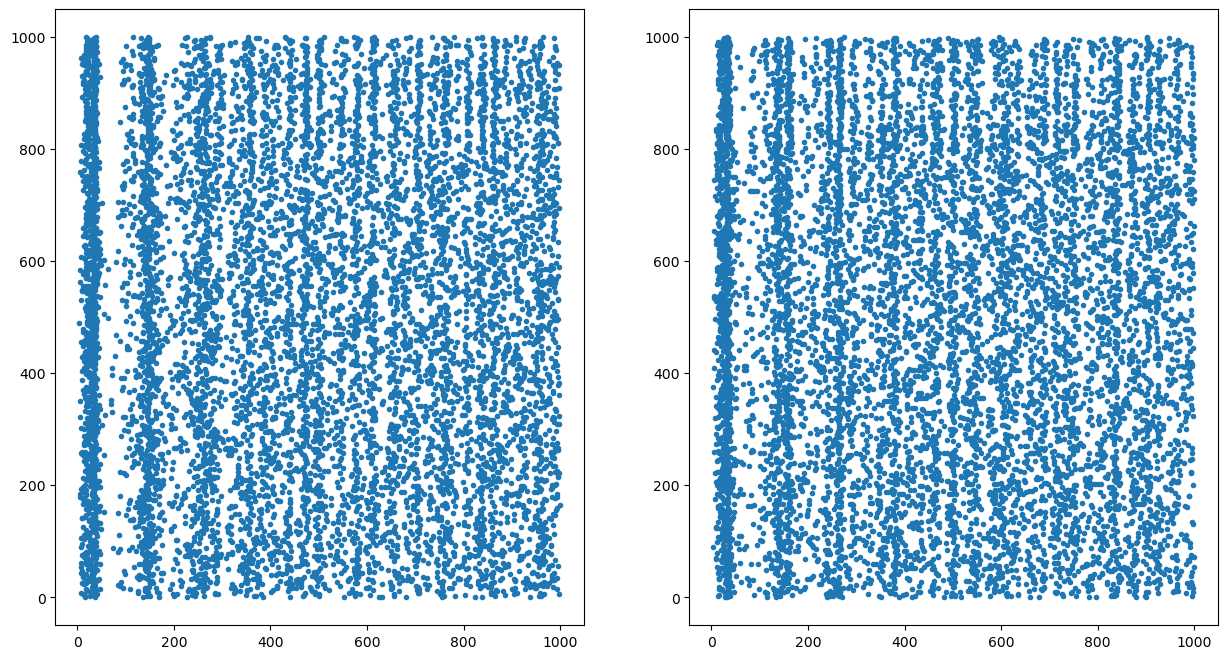

In [4]:
# Run four identical simulations sequentially
vals = parallel_run(method=run_network, number=8, measure_time=True, sequential=True)

# Run four identical simulations in parallel
vals = parallel_run(method=run_network, number=8, measure_time=True)

# Data analysis
t1, n1 = vals[0]
t2, n2 = vals[1]

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.plot(t1, n1, '.')
plt.subplot(122)
plt.plot(t2, n2, '.')
plt.show()